# Brick element Response

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

In [2]:
opst.load_ops_examples("Pier-Brick")
# or your model code here

In [3]:
# add gravity loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
_ = opst.pre.gen_grav_load(direction="z", factor=-9.81)

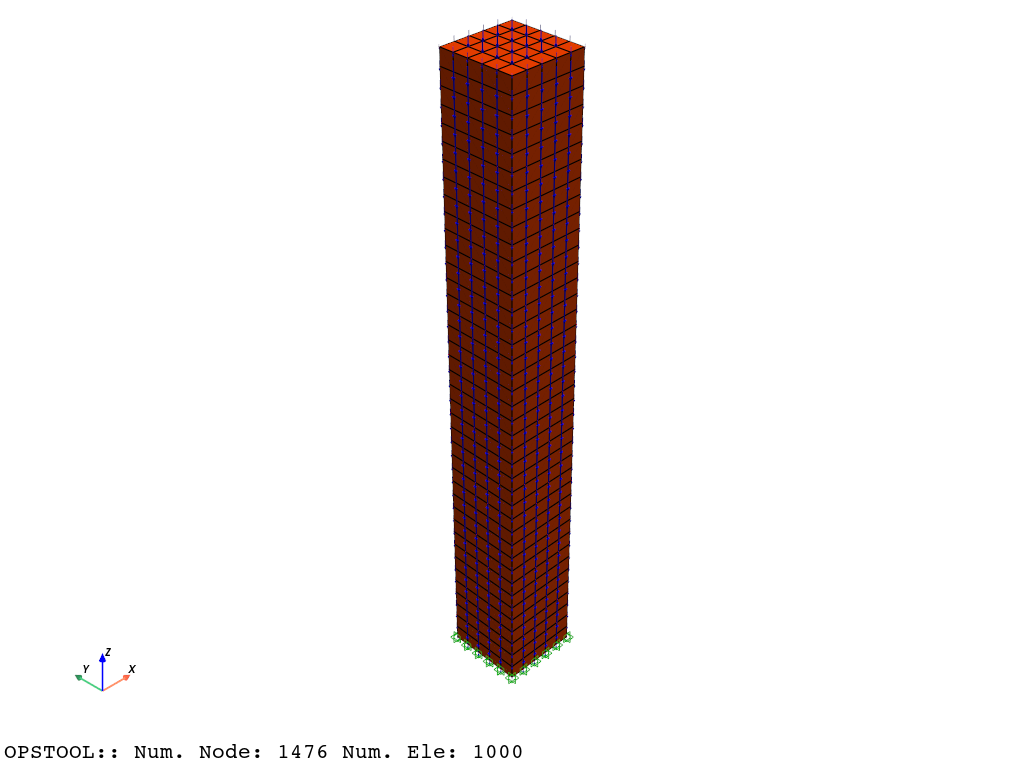

In [4]:
# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [5]:
Nsteps = 100

ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 1 / Nsteps)
# Create the analysis object
ops.analysis("Static")

In [6]:
ODB = opst.post.CreateODB(odb_tag=1, compute_mechanical_measures=True)
for i in range(Nsteps):
    # Perform the analysis step
    ops.analyze(1)
    # fetch the response step, every 10 steps for reducing the size of the ODB file
    if (i + 1) % 10 == 0:
        ODB.fetch_response_step()
    # ODB.fetch_response_step()   # or every step
ODB.save_response(zlib=True)  # save the response to a file, zlib=True for compression

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Result Reading

In [7]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Solid")

OPSTOOL ::  Loading Solid response data from .opstool.output/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [8]:
all_resp.data_vars

Data variables:
    Stresses        (time, eleTags, GaussPoints, stressDOFs) float32 2MB 0.0 ...
    Strains         (time, eleTags, GaussPoints, strainDOFs) float32 2MB 0.0 ...
    stressMeasures  (time, eleTags, GaussPoints, measures) float32 2MB 0.0 .....
    strainMeasures  (time, eleTags, GaussPoints, measures) float32 2MB 0.0 .....

``Stresses`` and ``Strains`` refer to the stress and strain at the Gauss points. 
Stress and strain consist of six components aligned with the global coordinate system, as well as additional stress measures:

In [9]:
print(all_resp.stressDOFs.data)
print(all_resp.strainDOFs.data)
print(all_resp.measures.data)

['sigma11' 'sigma22' 'sigma33' 'sigma12' 'sigma23' 'sigma13']
['eps11' 'eps22' 'eps33' 'eps12' 'eps23' 'eps13']
['p1' 'p2' 'p3' 'sigma_vm' 'tau_max' 'sigma_oct' 'tau_oct']


Although we analyzed 100 steps, we saved the data every 10 steps, so we only have data for 10 steps, and the time corresponds accordingly.

In [10]:
print(all_resp.time.data)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [11]:
all_resp.attrs  # attributes

{'sigma11, sigma22, sigma33': 'Normal stress (strain) along x, y, z.',
 'sigma12, sigma23, sigma13': 'Shear stress (strain).',
 'p1, p2, p3': 'Principal stresses (strains).',
 'eta_r': 'Ratio between the shear (deviatoric) stress and peak shear strength at the current confinement',
 'sigma_vm': 'Von Mises stress.',
 'tau_max': 'Maximum shear stress (strains).',
 'sigma_oct': 'Octahedral normal stress (strains).',
 'tau_oct': 'Octahedral shear stress (strains).'}

Below, we retrieve the stress and strain data, which is a **4D** array.
The dimensions are, in order, **('time', 'eleTags', 'GaussPoints', 'DOFs')**, and we can conveniently retrieve data based on these dimensions and their coordinates.

In [12]:
stresses = all_resp["Stresses"]
strains = all_resp["Strains"]
stress_measures = all_resp["stressMeasures"]
strain_measures = all_resp["strainMeasures"]
print(stresses.dims)

('time', 'eleTags', 'GaussPoints', 'stressDOFs')


In [13]:
stresses2 = stress_measures.sel(eleTags=1, measures="sigma_vm")
strains2 = strain_measures.sel(eleTags=1, measures="sigma_vm")
gauss_points = stresses2.coords["GaussPoints"].data

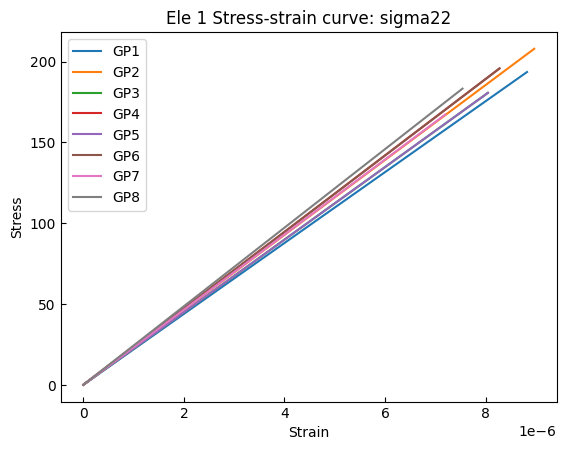

In [14]:
for gp_no in gauss_points:
    s = stresses2.sel(GaussPoints=gp_no)
    d = strains2.sel(GaussPoints=gp_no)
    plt.plot(d, s, label=f"GP{gp_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.legend()
plt.show()

We can also compute averages along a specific dimension. For example, below, we calculate the average stress at the Gauss points:

In [15]:
stresses2 = stress_measures.sel(measures="sigma_vm")
strains2 = strain_measures.sel(measures="sigma_vm")
stresses3 = stresses2.mean(dim="GaussPoints")
strains3 = strains2.mean(dim="GaussPoints")

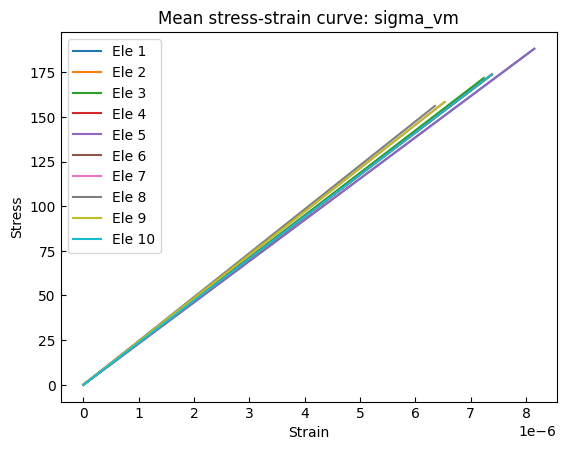

In [16]:
for eletag in np.arange(1, 11):
    s = stresses3.sel(eleTags=eletag)
    d = strains3.sel(eleTags=eletag)
    plt.plot(d, s, label=f"Ele {eletag}")
plt.title("Mean stress-strain curve: sigma_vm")
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.legend()
plt.show()